# Tutorial 02 - Loading and Visualizing Exported Surface Data

In this tutorial we will look at how to load surface data that was exported from Pupil Player into Python to generate aggregate heatmaps. We will follow these steps:

1. Load a reference image.
1. Load the data using `Pandas`
1. Visualize gaze data for 1 surface for 1 participant as a heatmap.
1. Visualize gaze data for 1 surface for multiple participants as a heatmap.

## 1 - Loading libraries and reference image

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.3f}'.format

magazine_cover_ref_image = np.zeros((1025, 800, 3)) #blank cover image of the same size

In this example, participants were asked to look at the cover of a magazine. We can quickly load the reference image (either from a file or from a url). 

_Note_ you can skip this if you do not want to load a reference image. 

In [2]:
def download_magazine_cover_image():
    from scipy.ndimage import rotate
    from urllib.request import urlopen, Request
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/535.19 (KHTML, like Gecko) Ubuntu/12.04 Chromium/18.0.1025.168 Chrome/18.0.1025.168 Safari/535.19'
    url = "https://cdn.technologyreview.com/i/images/mag.coverx1004_2.jpg?sw=800"
    file = urlopen(Request(url, headers={'User-Agent': user_agent}))
    image = np.fliplr(rotate(plt.imread(file, format='jpg'), 180))
    return image

magazine_cover_ref_image = download_magazine_cover_image()

## 2 - Loading Exported Surface Data

Now lets see how to load the exported gaze data for this surface. The file will be named with the pattern `gaze_positions_on_surface_<your-surface-name>_<uid>.csv`

In [3]:
# The recordings directory path and surface name used with the downloaded dataset
DEFAULT_RECORDINGS_PATH = './recordings/magazine_cover_recordings'
DEFAULT_SURFACE_NAME = 'magazine_cover'

SURFACE_FILE_PATH_PATTERN = os.path.join(
    "{recordings_dir}", "{recording_id}", "exports", "{export_id}", "surfaces",
    "gaze_positions_on_surface_{surface_name}_{surface_uid}.csv")

In [4]:
demo_surface_file_path = SURFACE_FILE_PATH_PATTERN.format(
    recordings_dir=DEFAULT_RECORDINGS_PATH, surface_name=DEFAULT_SURFACE_NAME,
    recording_id='000', export_id='000', surface_uid='1550027153.7953088',
)

print("Reading exported gaze on surface data at path:\n{}\n".format(demo_surface_file_path))

single_surface_df = pd.read_csv(demo_surface_file_path)
headers = single_surface_df.columns

print("Columns present in exported gaze on surface data:\n{}".format(list(headers)))

Reading exported gaze on surface data at path:
./recordings/magazine_cover_recordings/000/exports/000/surfaces/gaze_positions_on_surface_magazine_cover_1550027153.7953088.csv

Columns present in exported gaze on surface data:
['world_timestamp', 'world_frame_idx', 'gaze_timestamp', 'x_norm', 'y_norm', 'x_scaled', 'y_scaled', 'on_srf', 'confidence']


### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `world_timestamp` - The world camera timestamp at which the sample was recorded.
- `world_frame_idx` - The frame number of the world camera to which this sample is correlated.
- `gaze_timestamp` - The timestamp of the gaze position which is correlated with this world frame (note that there can be many gaze positions per world frame due to higher sampling rate of eye cameras relative to world cameras)
- `x_norm` - the normalized x position of the gaze relative to the surface. (0,0) is the bottom left corner of the surface; (1,1) is the top right corner of the surface. Note that coordinates outside of the 0-1 bounds are possible which means that the gaze is **not** on the surface. 
- `y_norm` - the normalized y position of the gaze relative to the surface.
- `x_scaled` and `y_scaled` - the position of the gaze relative to the surface scaled relative to the specified size of the surface. The size is defined in Pupil Player or Pupil Capture. 
- `on_srf` - boolean value if gaze is within the bounds of the surface
- `confidence` - confidence of the pupil detection

Let's take a look at a few values from our sample surface data!


In [5]:
single_gaze_on_surface_df = single_surface_df[single_surface_df.on_srf == True]

print("Gaze on (magazine surface) data:\n\n{}".format(single_gaze_on_surface_df[headers][:5]))

Gaze on (magazine surface) data:

     world_timestamp  world_frame_idx  gaze_timestamp  x_norm  y_norm  \
154       346700.334               19      346700.331   0.074   0.841   
155       346700.334               19      346700.333   0.027   0.791   
156       346700.334               19      346700.333   0.090   0.844   
157       346700.334               19      346700.336   0.112   0.854   
158       346700.334               19      346700.338   0.118   0.839   

     x_scaled  y_scaled  on_srf  confidence  
154    29.506   420.334    True       0.998  
155    10.648   395.685    True       0.373  
156    35.871   422.099    True       0.998  
157    44.990   427.177    True       0.998  
158    47.304   419.284    True       0.356  


We could take this example further by filtering out low `confidence` pupil detection values:

In [6]:
single_gaze_on_surface_df = single_surface_df[(single_surface_df.on_srf == True) & (single_surface_df.confidence > 0.8)]

print("Gaze on (magazine surface) data:\n\n{}".format(single_gaze_on_surface_df[headers][:5]))

Gaze on (magazine surface) data:

     world_timestamp  world_frame_idx  gaze_timestamp  x_norm  y_norm  \
154       346700.334               19      346700.331   0.074   0.841   
156       346700.334               19      346700.333   0.090   0.844   
157       346700.334               19      346700.336   0.112   0.854   
159       346700.334               19      346700.338   0.124   0.865   
160       346700.334               19      346700.341   0.137   0.876   

     x_scaled  y_scaled  on_srf  confidence  
154    29.506   420.334    True       0.998  
156    35.871   422.099    True       0.998  
157    44.990   427.177    True       0.998  
159    49.680   432.314    True       0.998  
160    54.732   437.812    True       0.998  


## 3 - Visualize aggregate gaze on surface for single participant

Now we visualize high confidence gaze data on this surface.

In [7]:
def visualize_gaze_on_surface(gaze_on_surface_df, surface_image):
    from scipy.ndimage.filters import gaussian_filter

    grid = surface_image.shape[:2] # this should match the real world size of the image
    heatmap_detail = 0.05 # this will determine the gaussian blur kerner of the image (higher number = more blur)

    # make the histogram
    hist, x_edges, y_edges = np.histogram2d(
        gaze_on_surface_df['y_norm'], gaze_on_surface_df['x_norm'],
        range=[[0, 1.0], [0, 1.0]], normed=False, bins=grid)

    # gaussian blur kernel as a function of grid/surface size
    filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
    filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1

    # display the histogram and reference image
    plt.figure(figsize=(8,6.25))

    ref_image = plt.imshow(surface_image, interpolation=None)

    single_heatmap = plt.imshow(
        gaussian_filter(hist, sigma=(filter_w, filter_h), order=0),
        interpolation=None, shape=grid, origin='lower', cmap='jet', alpha=0.6)

    plt.show()

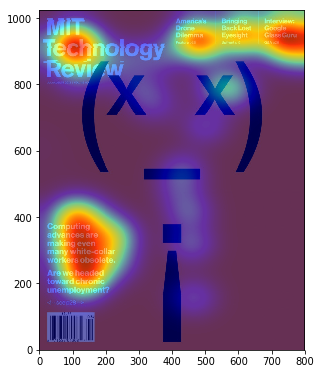

In [8]:
visualize_gaze_on_surface(
    gaze_on_surface_df=single_gaze_on_surface_df,
    surface_image=magazine_cover_ref_image)

## 4 - Visualize aggregate gaze on surface for multiple participants

We will now repeat steps 2 and 3 from above but will load the same `surface` from multiple recordings. This could be considered as an example of how to make an aggregate heatmap for multiple participants in a single study.


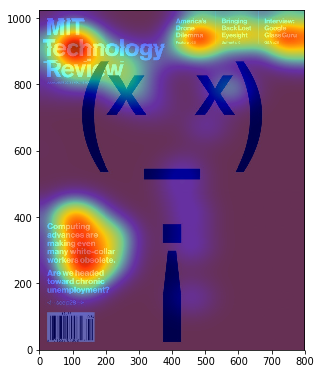

In [9]:
multi_surface_file_wildcard_path = SURFACE_FILE_PATH_PATTERN.format(
    recordings_dir=DEFAULT_RECORDINGS_PATH, surface_name=DEFAULT_SURFACE_NAME,
    recording_id='**', export_id='**', surface_uid='*',
)

multi_surface_file_paths = sorted(glob.glob(multi_surface_file_wildcard_path, recursive=True))

multi_surface_df = pd.DataFrame()

for fp in multi_surface_file_paths:
    frame = pd.read_csv(fp)
    multi_surface_df = multi_surface_df.append(frame)

# filter here again for only gaze on surface and where confidence is > 0.8    
multi_gazes_on_surfaces_df = multi_surface_df[(multi_surface_df.on_srf == True) & (multi_surface_df.confidence > 0.8)]

visualize_gaze_on_surface(
    gaze_on_surface_df=multi_gazes_on_surfaces_df,
    surface_image=magazine_cover_ref_image)